In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
from scipy.stats import normaltest
from scipy.stats import shapiro
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import os
from matplotlib.lines import Line2D

# CMA aging Atlas: All tissues analysis
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. All tissues data, Smart-seq2 assay in .h5ad format was used for further analysis.

In [2]:
# Creating folder for outputs
os.makedirs('../Khwaja_et_al_outputs/AllTissues')

## Importing and preprocessing data

In [3]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad('../Exp. 2_Tabula muris/Files/TM_all_smartseq.h5ad')

# Subsetting only for tissues of interest
adata = adata[adata.obs['tissue'].isin(['pancreas', 'heart', 'brain', 'lung', 'liver', 'kidney', 'limb muscle'])]

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\scanpy\preprocessing\_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [2]:
# Import h5ad file with CMA score calculations for further analysis. 
adata = sc.read_h5ad('../Khwaja_et_al_outputs/AllTissues/All_processed.h5ad')

## CMA score calculation

In [5]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx')

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 333.26it/s]
47484it [02:49, 280.71it/s]


## Plotting CMA score UMAP

In [7]:
# Checking tissues in adata.obs
print(list(barcode.tissue.unique()))

['pancreas', 'limb muscle', 'heart', 'brain', 'lung', 'liver', 'kidney']


In [8]:
# Reordering them for plotting purposes
barcode['tissue'].cat.reorder_categories(['brain', 'heart', 'kidney', 'liver', 'lung', 'limb muscle', 'pancreas'], 
                                            inplace=True)

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\30207695.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  barcode['tissue'].cat.reorder_categories(['brain', 'heart', 'kidney', 'liver', 'lung', 'limb muscle', 'pancreas'],


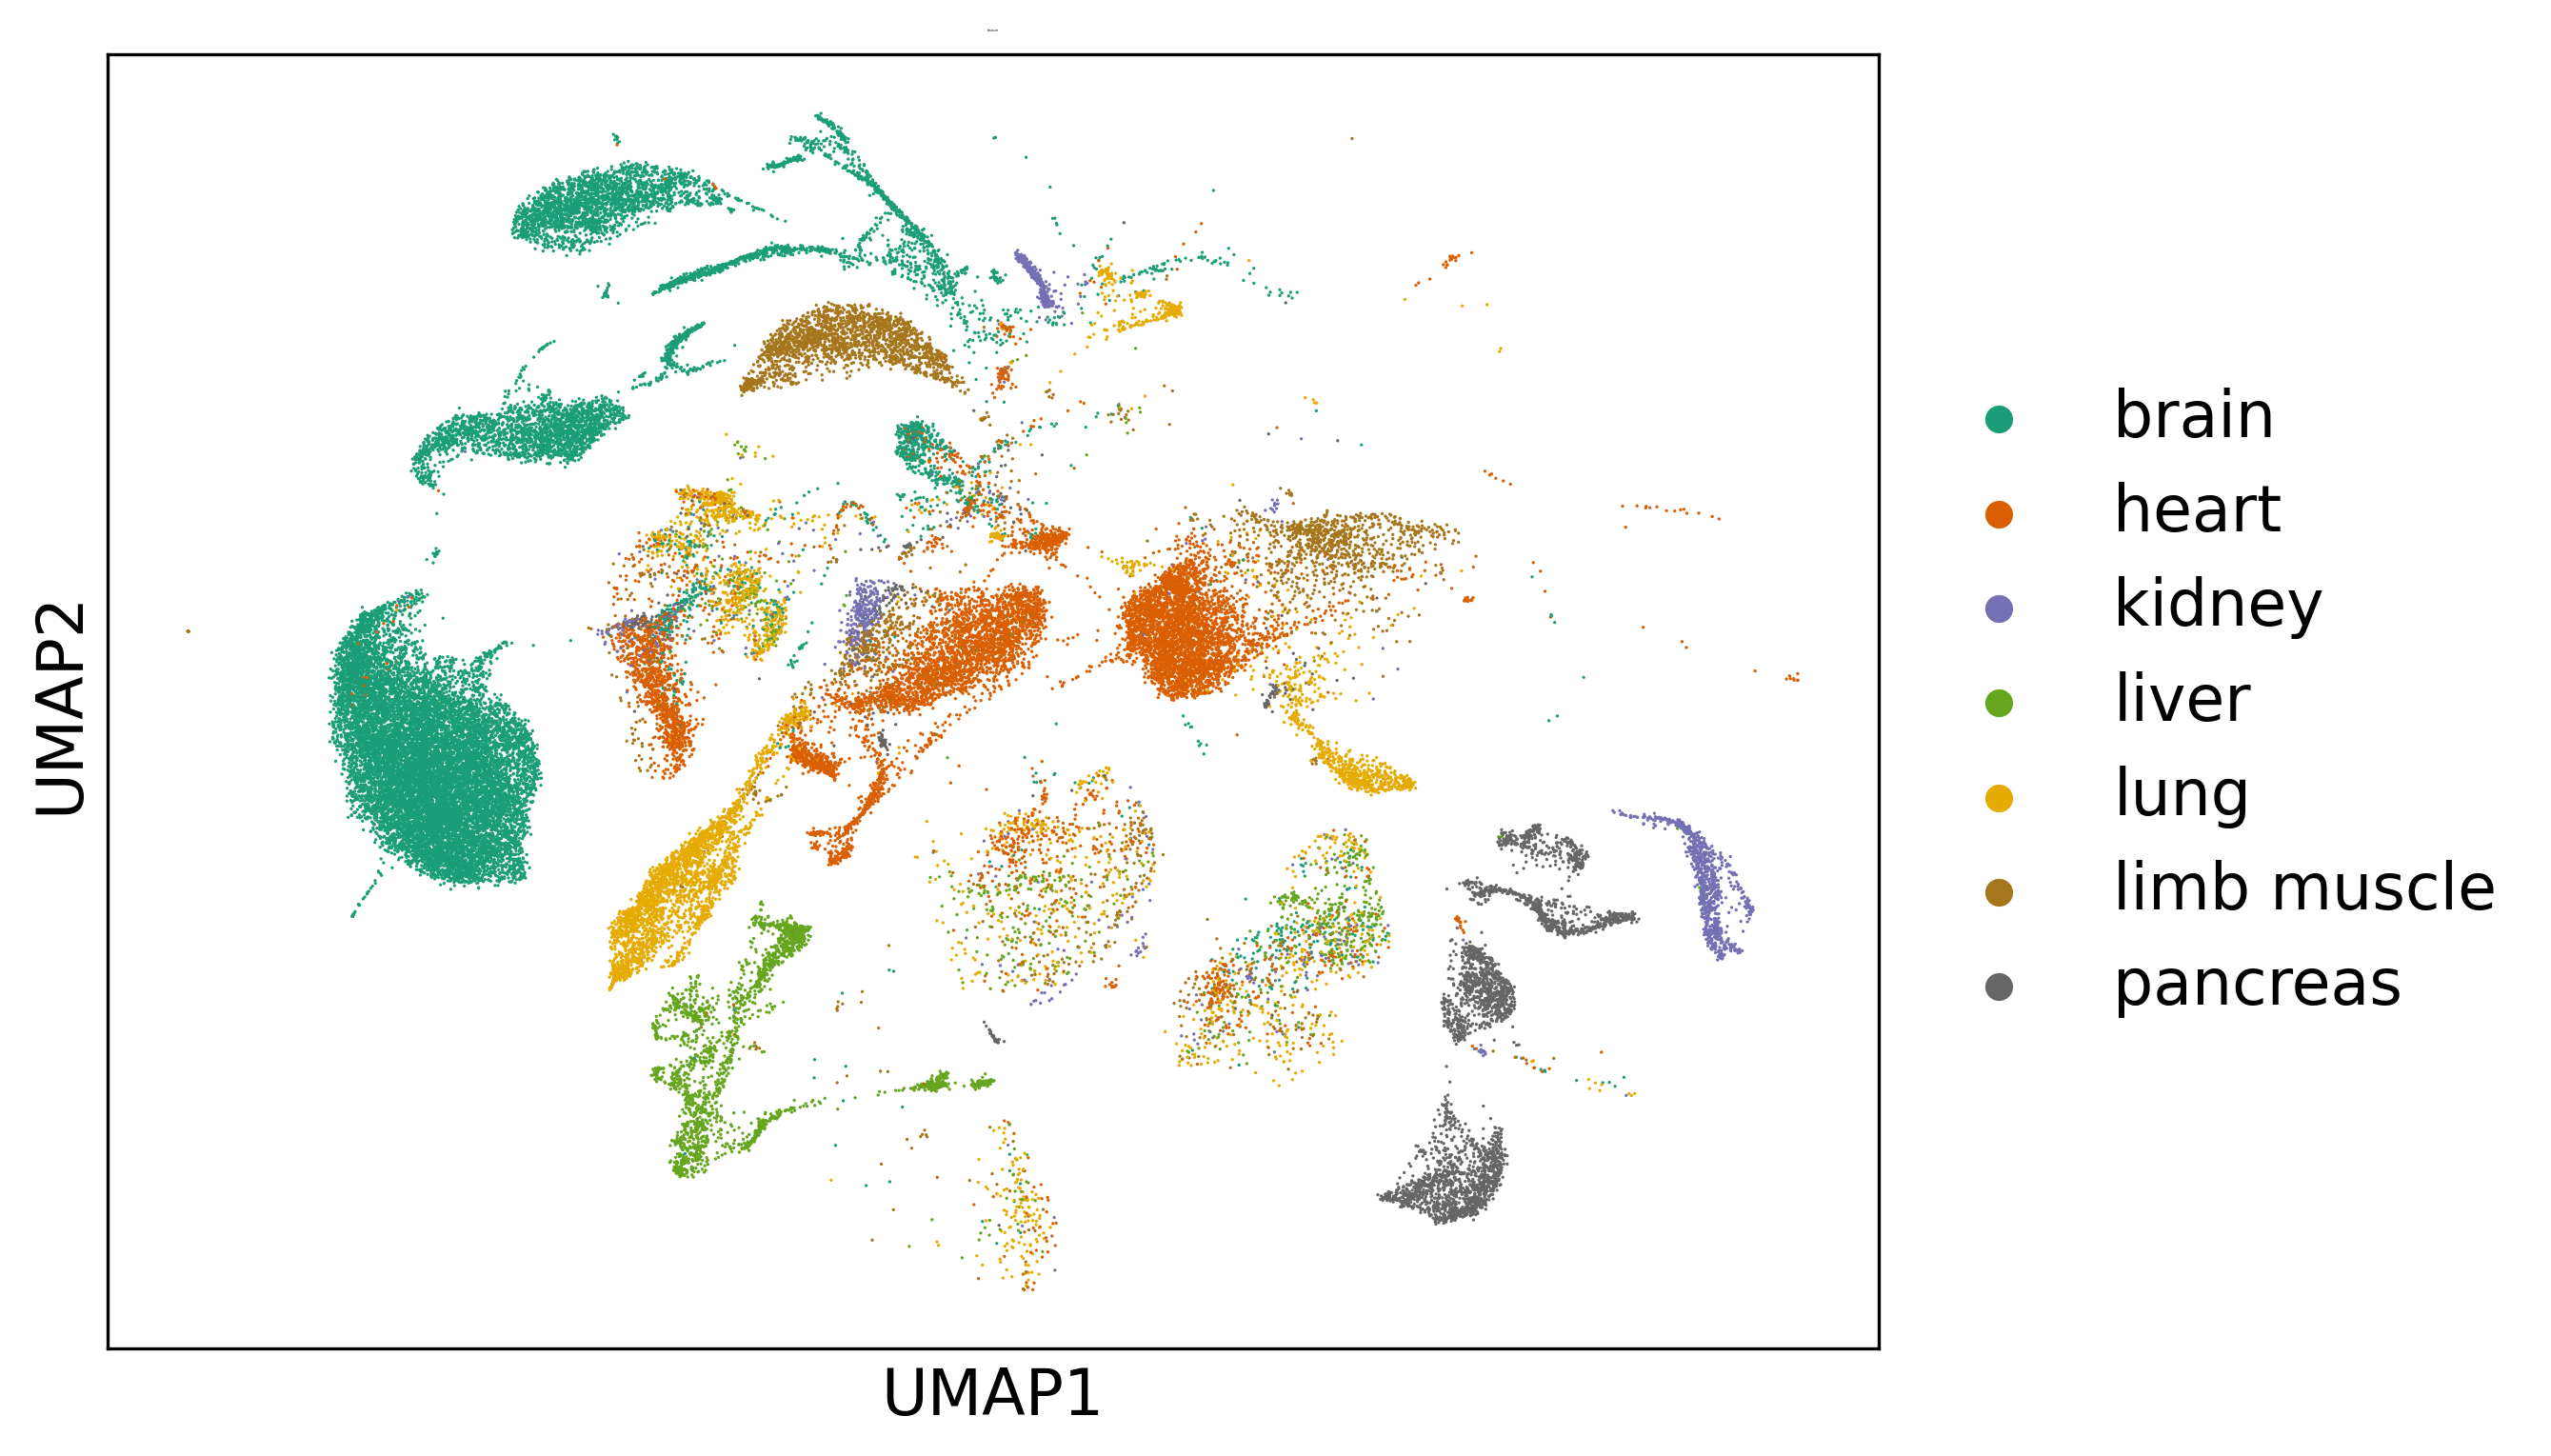

In [33]:
# UMAP for tissues
with plt.rc_context({"figure.figsize": (8, 6), "figure.dpi": (300), "axes.labelsize":(16), "axes.titlesize":(0)}):
    sc.pl.umap(adata, color=['tissue'], palette='Dark2', legend_fontsize=16, show=False)
plt.savefig('../Khwaja_et_al_outputs/AllTissues/UMAP_tissues.png', bbox_inches='tight')

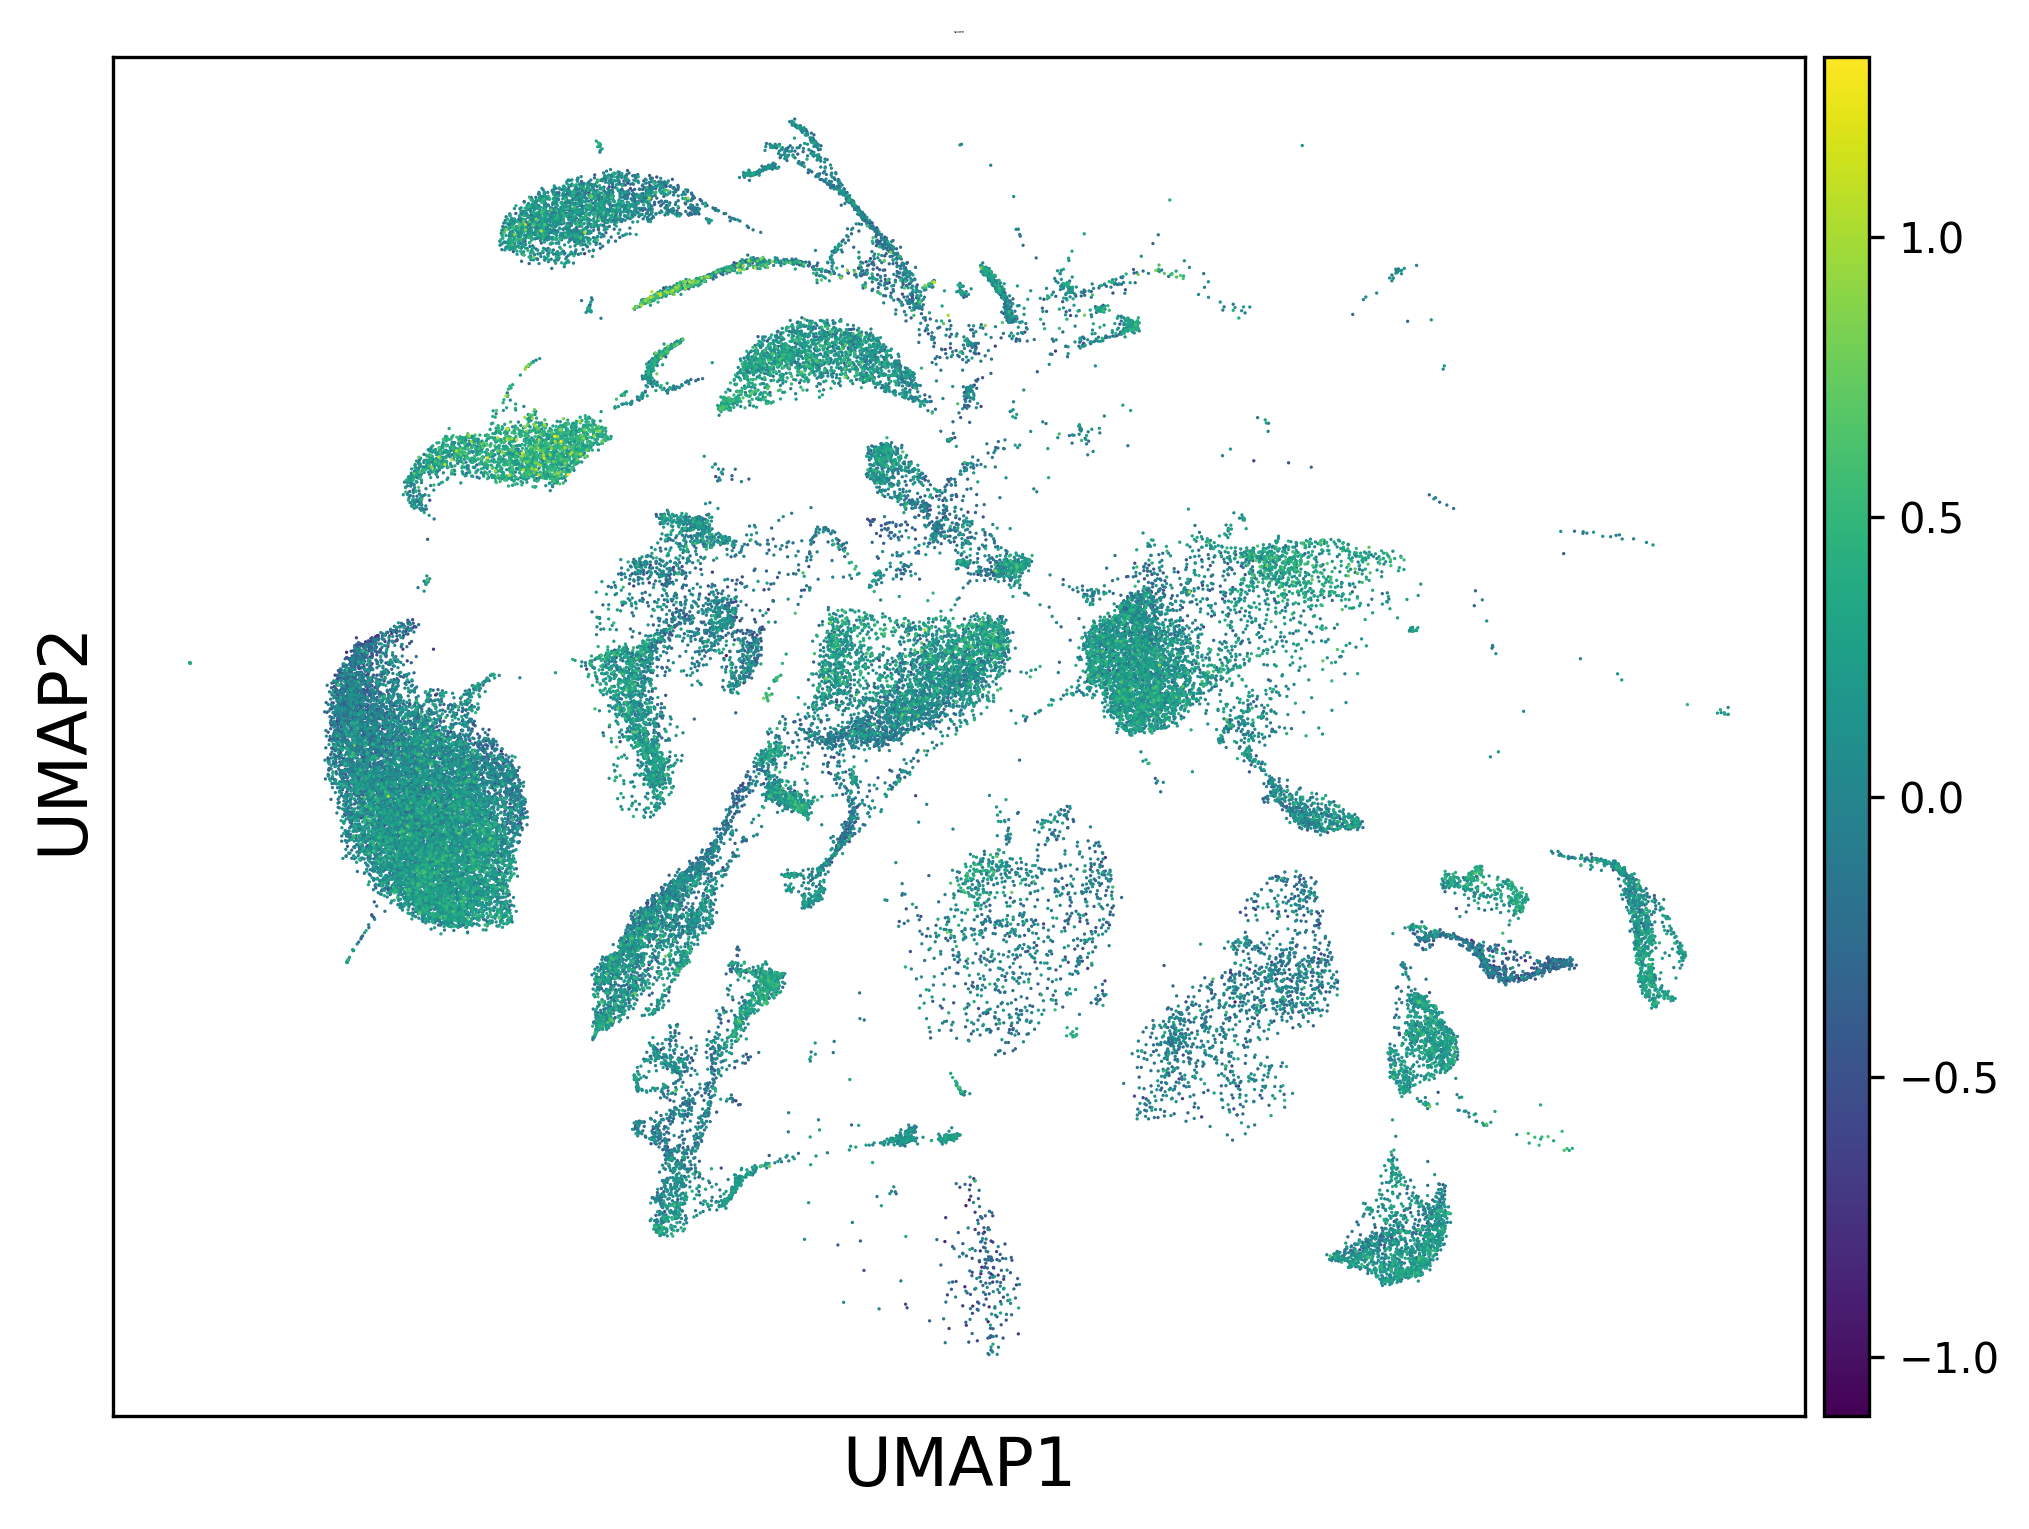

In [34]:
# UMAP for CMA score
with plt.rc_context({"figure.figsize": (8, 6), "figure.dpi": (300), "axes.labelsize":(16), "axes.titlesize":(0)}):
    sc.pl.umap(adata, color=['score'], palette='Dark2', legend_fontsize=16, show=False)
plt.savefig('../Khwaja_et_al_outputs/AllTissues/UMAP_score.png', bbox_inches='tight')

In [39]:
# Stats of number of cell types per tissue
df_numbers = pd.crosstab(adata.obs.tissue, adata.obs.cell_type)
df_numbers.to_excel('../Khwaja_et_al_outputs/AllTissues/Raw_data.xlsx', 'Cells_n', index=True)

## CMA net score/cell type (fold over whole tissue)

In [57]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-24m'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = '18-24m'
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,score,umap_density_tissue,_tmp_embedding_density_column_7382_,new_age
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6891.192383,31,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,-0.145108,0.599144,0.599144,18-24m
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B000927,nan,facs,18_46_F,Muscle Diaphragm,2789,2543.752930,12,...,normal,Mus musculus,female,limb muscle,na,18 month-old stage,-0.104981,0.939589,-1.000000,18-24m
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3588.732910,1,...,normal,Mus musculus,female,heart,na,18 month-old stage,0.063537,0.017321,-1.000000,18-24m
A10_B003294_B007450_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B003294,nan,facs,18_47_F,Muscle forelimb and hindlimb,1838,3994.461182,12,...,normal,Mus musculus,female,limb muscle,na,18 month-old stage,0.184838,0.768057,-1.000000,18-24m
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,6017.255371,31,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,0.009996,0.838215,0.838215,18-24m


In [58]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,organism,sex,tissue,self_reported_ethnicity,development_stage,score,umap_density_tissue,_tmp_embedding_density_column_7382_,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6891.192383,31,...,Mus musculus,male,pancreas,na,18 month-old stage,-0.145108,0.599144,0.599144,18-24m,-0.200220
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B000927,nan,facs,18_46_F,Muscle Diaphragm,2789,2543.752930,12,...,Mus musculus,female,limb muscle,na,18 month-old stage,-0.104981,0.939589,-1.000000,18-24m,-0.160093
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3588.732910,1,...,Mus musculus,female,heart,na,18 month-old stage,0.063537,0.017321,-1.000000,18-24m,0.008425
A10_B003294_B007450_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B003294,nan,facs,18_47_F,Muscle forelimb and hindlimb,1838,3994.461182,12,...,Mus musculus,female,limb muscle,na,18 month-old stage,0.184838,0.768057,-1.000000,18-24m,0.129726
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,6017.255371,31,...,Mus musculus,male,pancreas,na,18 month-old stage,0.009996,0.838215,0.838215,18-24m,-0.045116


### Cell types stats

In [99]:
tissues = ['pancreas', 'limb muscle', 'heart', 'brain', 'lung', 'liver', 'kidney']

In [60]:
# Function for testing normality using D'Agostino-Pearson of different cell types and ages
def normalidad (df, tipo, años):
    long = []
    cell = []
    age = []
    estadistica=[]
    pval=[]
    result=[]   
    
    for x in tipo:
        for y in años:
            mydata = df[(df['tissue']== x) & (df['new_age']== y)]
            n = len(mydata.index)
            data = list(mydata.net_score)            
            stat, p = normaltest(data)
            long.append(n)
            cell.append(x)
            age.append(y)
            estadistica.append(stat)
            pval.append(p)
            if p > 0.05:
                result.append("Normal")
            else:
                result.append("Not normal")    
    df_norm = pd.DataFrame({"Cell": cell, "Age": age, "n": long, "Stat":estadistica, "p value": pval, "Result":result})
    return(df_norm)

In [61]:
normalidad(barcode, tipo=tissues, años=['3m', '18-24m'])

,Cell,Age,n,Stat,p value,Result
0,pancreas,3m,1588,66.065554,4.508657e-15,Not normal
1,pancreas,18-24m,1796,47.124610,5.848182e-11,Not normal
2,limb muscle,3m,1102,5.692543,5.806041e-02,Normal
3,limb muscle,18-24m,2753,2.926104,2.315286e-01,Normal
4,heart,3m,4433,17.542805,1.551059e-04,Not normal
5,heart,18-24m,5236,9.795442,7.463574e-03,Not normal
6,brain,3m,7974,116.549303,4.916322e-26,Not normal
7,brain,18-24m,12692,43.371317,3.819778e-10,Not normal
8,lung,3m,1381,9.203157,1.003598e-02,Not normal
9,lung,18-24m,3837,7.956079,1.872231e-02,Not normal


In [63]:
# Calculating T test for normally distributed cell types
for i in ['limb muscle']:
    # First Levene test for equal variances
    group3 = list(barcode[barcode.tissue==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.tissue==i][barcode.new_age=='18-24m']['net_score'])
    print('Levene test for {}'.format(i.title()))
    stat, p = stats.levene(group3, group18_24)
    print("Levene's test pval for {} = {}".format(i.title(), p))
    
    # T test
    if p < 0.05:
        stat2, p2 = stats.ttest_ind(group3, group18_24, equal_var=False)
        print('T test for {}, with no equal var.'.format(i))
        print("T test pval = " + str(p2))
        print('\n')
        
    else:
        stat2, p2 = stats.ttest_ind(group3, group18_24, equal_var=True)
        print('T test for {}, assuming equal var.'.format(i))
        print("T test pval = " + str(p2))
        print('\n')

Levene test for Limb Muscle
Levene's test pval for Limb Muscle = 0.1644969064060064
T test for limb muscle, assuming equal var.
T test pval = 8.566128092445266e-38




C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\2064730461.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.tissue==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\2064730461.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.tissue==i][barcode.new_age=='18-24m']['net_score'])


In [65]:
# Calculating MWU test for not normally distributed cell types
for i in ['pancreas', 'brain', 'heart', 'lung', 'liver', 'kidney']:
    group3 = list(barcode[barcode.tissue==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.tissue==i][barcode.new_age=='18-24m']['net_score'])
    print('{} statistics'.format(i.title()))
    stat, p = stats.mannwhitneyu(group3, group18_24)
    print("MWU test pval = " + str(p))
    print('\n')

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\4100250119.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.tissue==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\4100250119.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.tissue==i][barcode.new_age=='18-24m']['net_score'])


Pancreas statistics
MWU test pval = 1.829296863158664e-21


Brain statistics
MWU test pval = 1.782744293965251e-215


Heart statistics
MWU test pval = 6.852970253503826e-18


Lung statistics
MWU test pval = 0.014384072469056253


Liver statistics
MWU test pval = 1.2612811234711927e-17


Kidney statistics
MWU test pval = 0.7700787412254051




### Net score graph

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\2972858903.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y1= np.mean(barcode[barcode.tissue =='brain'][barcode.new_age=='18-24m']['net_score']) - (0.015)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\2972858903.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y2= np.mean(barcode[barcode.tissue =='heart'][barcode.new_age=='18-24m']['net_score']) - (0.015)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\2972858903.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y3= np.mean(barcode[barcode.tissue =='kidney'][barcode.new_age=='18-24m']['net_score']) - (0.015)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\2972858903.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y4= np.mean(barcode[barcode.tissue =='liver'][barcode.new_age=='18-24m']['net_score']) - (0.015)
C:\Users\Adrian\AppData\Loc

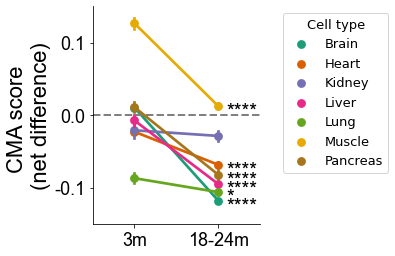

In [73]:
# CMA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='net_score', data=barcode, hue='tissue', order=["3m", "18-24m"], 
              hue_order=['brain', 'heart', 'kidney', 'liver', 'lung', 'limb muscle', 'pancreas'], palette="Dark2", ci=68)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(-0.15, 0.15) 
ax.set_yticks([-0.10, 0.00, 0.10])
ax.set_yticklabels([-0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})

# Legend
tissues = ['Brain', 'Heart', 'Kidney', 'Liver', 'Lung', 'Muscle', 'Pancreas']
h, l = ax.get_legend_handles_labels()
ax.legend(h, tissues, bbox_to_anchor=(1.1, 1), title="Cell type", title_fontsize = "13", fontsize=13) 

# Stats
x1= 1.1   
y1= np.mean(barcode[barcode.tissue =='brain'][barcode.new_age=='18-24m']['net_score']) - (0.015)
y2= np.mean(barcode[barcode.tissue =='heart'][barcode.new_age=='18-24m']['net_score']) - (0.015)
y3= np.mean(barcode[barcode.tissue =='kidney'][barcode.new_age=='18-24m']['net_score']) - (0.015)
y4= np.mean(barcode[barcode.tissue =='liver'][barcode.new_age=='18-24m']['net_score']) - (0.015)
y5= np.mean(barcode[barcode.tissue =='lung'][barcode.new_age=='18-24m']['net_score']) - (0.015)
y6= np.mean(barcode[barcode.tissue =='limb muscle'][barcode.new_age=='18-24m']['net_score']) - (0.015)
y7= np.mean(barcode[barcode.tissue =='pancreas'][barcode.new_age=='18-24m']['net_score']) - (0.015)

plt.text(x1, y1, "****", fontsize=20, **hfont)
plt.text(x1, y2, "****", fontsize=20, **hfont)
plt.text(x1, y4, "****", fontsize=20, **hfont)
plt.text(x1, y5, "*", fontsize=20, **hfont)
plt.text(x1, y6, "****", fontsize=20, **hfont)
plt.text(x1, y7, "****", fontsize=20, **hfont)

plt.savefig('../Khwaja_et_al_outputs/AllTissues/Tissues_ns.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data 

In [79]:
# Extracting raw values for pointplot graphic
long = []
tejido = []
age = []
mean=[]
sem=[]

for x in tissues:
    for y in ['3m', '18-24m']:
        n = len(barcode[barcode['tissue']== x][barcode['new_age']== y].index)
        m = np.mean(barcode[barcode['tissue']== x][barcode['new_age']== y]['net_score'])
        s = stats.sem(np.array(barcode[barcode['tissue']== x][barcode['new_age']== y]['net_score']))
        
        long.append(n)
        tejido.append(x)
        age.append(y)
        mean.append(m)
        sem.append(s)
        
df_raw = pd.DataFrame({"Tissue": tejido, "Age": age, "n": long, "Mean":mean, "SEM": sem})
with pd.ExcelWriter("../Khwaja_et_al_outputs/AllTissues/Raw_data.xlsx", mode="a", if_sheet_exists='replace',
                    engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="Nsbytissue", index=False)

df_raw

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\2383999762.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['tissue']== x][barcode['new_age']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\2383999762.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['tissue']== x][barcode['new_age']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\2383999762.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(np.array(barcode[barcode['tissue']== x][barcode['new_age']== y]['net_score']))


,Tissue,Age,n,Mean,SEM
0,pancreas,3m,1588,0.010805,0.006182
1,pancreas,18-24m,1796,-0.082235,0.006642
2,limb muscle,3m,1102,0.126538,0.007237
3,limb muscle,18-24m,2753,0.012496,0.004739
4,heart,3m,4433,-0.023019,0.003687
5,heart,18-24m,5236,-0.068472,0.003513
6,brain,3m,7974,0.010246,0.003081
7,brain,18-24m,12692,-0.117927,0.002458
8,lung,3m,1381,-0.087087,0.006870
9,lung,18-24m,3837,-0.106282,0.004221


## CMA net score/tissue & cell type (fold over whole tissue)

In [83]:
# Checking all cell types/tissue
for i in tissues:
    print(i.title())
    df = barcode[barcode["tissue"]==i].reset_index(drop=True)
    print(list(df.cell_type.unique()))
    print('\n')

Pancreas
['type B pancreatic cell', 'pancreatic acinar cell', 'pancreatic A cell', 'pancreatic D cell', 'endothelial cell', 'leukocyte', 'pancreatic ductal cell', 'pancreatic stellate cell', 'pancreatic PP cell']


Limb Muscle
['skeletal muscle satellite cell', 'T cell', 'mesenchymal stem cell', 'macrophage', 'endothelial cell', 'B cell']


Heart
['B cell', 'fibroblast of cardiac tissue', 'endothelial cell of coronary artery', 'monocyte', 'macrophage', 'endocardial cell', 'valve cell', 'regular atrial cardiac myocyte', 'T cell', 'smooth muscle cell', 'regular ventricular cardiac myocyte']


Brain
['oligodendrocyte', 'CD8-positive, alpha-beta T cell', 'microglial cell', 'astrocyte', 'ependymal cell', 'brain pericyte', 'endothelial cell', 'interneuron', 'macrophage', 'neuron', 'oligodendrocyte precursor cell', 'Bergmann glial cell', 'neuroepithelial stem cell', 'T cell', 'neural stem cell', 'mature NK T cell', 'medium spiny neuron']


Lung
['bronchial smooth muscle cell', 'fibroblast of 

In [60]:
# Creating new cathegories for cell types combinig some in some tissues
for j in barcode.index:    
    # Lung
    if barcode.loc[j, 'cell_type'] == 'type I pneumocyte' or barcode.loc[j, 'cell_type'] == 'type II pneumocyte':        
        barcode.loc[j, 'new_cell'] = 'pneumocyte'

    elif barcode.loc[j, 'cell_type'] == 'fibroblast of lung' or barcode.loc[j, 'cell_type'] == 'adventitial cell' or barcode.loc[j, 'cell_type'] == 'pulmonary interstitial fibroblast':                
        barcode.loc[j, 'new_cell'] = 'lung fibroblast'
    
    elif barcode.loc[j, 'cell_type'] == 'vein endothelial cell' or barcode.loc[j, 'cell_type'] == 'endothelial cell of lymphatic vessel':                
        barcode.loc[j, 'new_cell'] = 'lung endothelial cell'
        
    # Heart
    elif barcode.loc[j, 'cell_type'] == 'regular atrial cardiac myocyte' or barcode.loc[j, 'cell_type'] == 'regular ventricular cardiac myocyte':        
        barcode.loc[j, 'new_cell'] = 'myocyte'

    elif barcode.loc[j, 'cell_type'] == 'fibroblast of cardiac tissue':
        barcode.loc[j, 'new_cell'] = 'heart fibroblast'
    
    elif barcode.loc[j, 'cell_type'] == 'endothelial cell of coronary artery':
        barcode.loc[j, 'new_cell'] = 'heart endothelial cell'
    
    # Kidney
    elif barcode.loc[j, 'cell_type'] == 'kidney collecting duct epithelial cell' or barcode.loc[j, 'cell_type'] == 'kidney collecting duct principal cell':
        barcode.loc[j, 'new_cell'] = 'collecting duct epithelial cell'
    
    elif barcode.loc[j, 'cell_type'] == 'epithelial cell of proximal tubule':
        barcode.loc[j, 'new_cell'] = 'proximal tubule epithelial cell'
    
    # Rest of cells
    else:
        barcode.loc[j, 'new_cell'] = barcode.loc[j, 'cell_type']

In [84]:
cell_dict = {'brain': ['neuron', 'interneuron', 'astrocyte', 'oligodendrocyte', 'microglial cell'],
            'heart':['myocyte', 'smooth muscle cell', 'fibroblast', 'endothelial cell'],
            'kidney':['mesangial cell', 'fenestrated cell', 'proximal tubule epithelial cell', 
                      'collecting duct epithelial cell'],
            'liver':['hepatocyte', 'Kupffer cell'],
            'lung': ['pneumocyte', 'fibroblast', 'endothelial cell'],
            'limb muscle':['skeletal muscle satellite cell'],
            'pancreas':['pancreatic acinar cell', 'pancreatic A cell', 'type B pancreatic cell']}

In [92]:
# Calculating net score with mean of tissue score as basal
for maj_cell in tqdm(np.unique(barcode['tissue'])):
    
    µ = np.mean(barcode[barcode['tissue']==maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['tissue'] == maj_cell].index:
    
        barcode.loc[cell_index, 'tissue_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\3093813696.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['tissue']==maj_cell][barcode['new_age'] == '3m']['score'])
 14%|████████████                                                                        | 1/7 [00:02<00:15,  2.54s/it]C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\3093813696.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['tissue']==maj_cell][barcode['new_age'] == '3m']['score'])
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.23it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,tissue,self_reported_ethnicity,development_stage,score,umap_density_tissue,_tmp_embedding_density_column_7382_,new_age,net_score,new_cell,tissue_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6891.192383,31,...,pancreas,na,18 month-old stage,-0.145108,0.599144,0.599144,18-24m,-0.200220,type B pancreatic cell,-0.211025
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B000927,nan,facs,18_46_F,Muscle Diaphragm,2789,2543.752930,12,...,limb muscle,na,18 month-old stage,-0.104981,0.939589,-1.000000,18-24m,-0.160093,skeletal muscle satellite cell,-0.286631
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3588.732910,1,...,heart,na,18 month-old stage,0.063537,0.017321,-1.000000,18-24m,0.008425,B cell,0.031444
A10_B003294_B007450_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B003294,nan,facs,18_47_F,Muscle forelimb and hindlimb,1838,3994.461182,12,...,limb muscle,na,18 month-old stage,0.184838,0.768057,-1.000000,18-24m,0.129726,skeletal muscle satellite cell,0.003188
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,6017.255371,31,...,pancreas,na,18 month-old stage,0.009996,0.838215,0.838215,18-24m,-0.045116,type B pancreatic cell,-0.055921


### Stats

In [110]:
# Function for testing normality using D'Agostino-Pearson of different cell types and ages
def normalidad (df, tejido, años):
    long = []
    cell = []
    age = []
    estadistica=[]
    pval=[]
    result=[]   
    tej = []
    for x in cell_dict[i]:
        for y in años:            
            mydata = df[(df['tissue']==i) & (df['new_cell']== x) & (df['new_age']== y)]
            n = len(mydata.index)
            data = list(mydata.net_score)            
            stat, p = normaltest(data)
            tej.append(i)
            long.append(n)
            cell.append(x)
            age.append(y)
            estadistica.append(stat)
            pval.append(p)
            if p > 0.05:
                result.append("Normal")
            else:
                result.append("Not normal")
            
    df_norm = pd.DataFrame({"Tissue": tej, "Cell": cell, "Age": age, "n": long, "Stat":estadistica, "p value": pval, 
                            "Result":result})
    print(df_norm)
    print('\n')

In [117]:
for i in tissues:
    normalidad(barcode, tejido=i, años=['3m', '18-24m'])

     Tissue                    Cell     Age    n       Stat   p value  \
0  pancreas  pancreatic acinar cell      3m  191   0.538631  0.763902   
1  pancreas  pancreatic acinar cell  18-24m  385   3.110675  0.211118   
2  pancreas       pancreatic A cell      3m  364   0.325677  0.849729   
3  pancreas       pancreatic A cell  18-24m  157   3.476487  0.175829   
4  pancreas  type B pancreatic cell      3m  522   7.017154  0.029939   
5  pancreas  type B pancreatic cell  18-24m  820  19.013799  0.000074   

       Result  
0      Normal  
1      Normal  
2      Normal  
3      Normal  
4  Not normal  
5  Not normal  


        Tissue                            Cell     Age     n      Stat  \
0  limb muscle  skeletal muscle satellite cell      3m   535  4.008893   
1  limb muscle  skeletal muscle satellite cell  18-24m  1298  0.679877   

    p value  Result  
0  0.134735  Normal  
1  0.711814  Normal  


  Tissue                Cell     Age     n       Stat       p value  \
0  heart    

In [118]:
# Calculating T test for normally distributed cell types
celula = []
lev = []
equal = []
pval = []
sig = []

for i in ['pancreatic acinar cell', 'pancreatic A cell', 'skeletal muscle satellite cell', 'myocyte',
         'smooth muscle cell', 'pneumocyte', 'fibroblast', 'endothelial cell', 'mesangial cell', 'fenestrated cell', 
          'collecting duct epithelial cell']:
    
    # First Levene test for equal variances
    if i == 'fibroblast' or i=='endothelial cell':
        group3 = list(barcode[barcode.tissue=='lung'][barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
        group18_24 = list(barcode[barcode.tissue=='lung'][barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
    else:
        group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
        group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
    stat, p = stats.levene(group3, group18_24)
        
    # T test
    if p < 0.05:
        s = 'not equal'
        stat2, p2 = stats.ttest_ind(group3, group18_24, equal_var=False)
                
    else:
        s = 'equal var'
        stat2, p2 = stats.ttest_ind(group3, group18_24, equal_var=True)
    if p2 < 0.05 and p2 > 0.01:
        c = '*'
    elif p2 > 0.05:
        c = 'ns'
    elif p2 < 0.01 and p2 > 0.005:
        c = '**'
    elif p2< 0.005 and p2>0.001:
        c = '***'
    else:
        c = '****'
    
    celula.append(i)
    lev.append(p)
    equal.append(s)
    pval.append(p2)
    sig.append(c)
    
    df_pval = pd.DataFrame({"Cell": celula, "Levene": lev, "Variance": equal, "Ttest":pval, 'Signigicance':sig})

df_pval

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\940304054.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\940304054.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\940304054.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.tissue=='lung'][barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\940304054.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.tissue=='lung'][barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])


,Cell,Levene,Variance,Ttest,Signigicance
0,pancreatic acinar cell,0.211551,equal var,1.145096e-01,ns
1,pancreatic A cell,0.955059,equal var,8.007825e-02,ns
2,skeletal muscle satellite cell,0.623964,equal var,1.629520e-21,****
3,myocyte,0.868669,equal var,6.299279e-04,****
4,smooth muscle cell,0.476210,equal var,3.518450e-02,*
5,pneumocyte,0.000269,not equal,5.401902e-04,****
6,fibroblast,0.899567,equal var,2.117760e-01,ns
7,endothelial cell,0.301611,equal var,9.004913e-02,ns
8,mesangial cell,0.831462,equal var,7.918753e-01,ns
9,fenestrated cell,0.797759,equal var,9.075409e-01,ns


In [120]:
# Calculating MWU for not normally distributed cell types
celula = []
pval = []
sig = []

for i in ['type B pancreatic cell', 'fibroblast', 'endothelial cell', 'neuron', 'interneuron', 'astrocyte',
         'oligodendrocyte', 'microglial cell', 'hepatocyte', 'Kupffer cell', 'proximal tubule epithelial cell']:
    
    if i == 'fibroblast' or i=='endothelial cell':
        group3 = list(barcode[barcode.tissue=='heart'][barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
        group18_24 = list(barcode[barcode.tissue=='heart'][barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
    else:
        group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
        group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
    
    stat, p = stats.mannwhitneyu(group3, group18_24)
    
    # First Levene test for equal variances
    group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
    stat, p = stats.levene(group3, group18_24)  
    
    if p < 0.05 and p > 0.01:
        c = '*'
    elif p > 0.05:
        c = 'ns'
    elif p < 0.01 and p > 0.005:
        c = '**'
    elif p< 0.005 and p>0.001:
        c = '***'
    else:
        c = '****'
    
    celula.append(i)
    pval.append(p)
    sig.append(c)
    
    df_pval = pd.DataFrame({"Cell": celula, "Ttest":pval, 'Signigicance':sig})

df_pval

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\119429685.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\119429685.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\119429685.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\119429685.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4612\119429685.py:10: UserWarning: Bool

,Cell,Ttest,Signigicance
0,type B pancreatic cell,1.054284e-05,****
1,fibroblast,3.350871e-01,ns
2,endothelial cell,6.969390e-01,ns
3,neuron,2.650147e-03,***
4,interneuron,3.689488e-02,*
5,astrocyte,3.058306e-01,ns
6,oligodendrocyte,1.551644e-03,***
7,microglial cell,1.069035e-11,****
8,hepatocyte,5.351977e-04,****
9,Kupffer cell,8.849440e-01,ns


In [128]:
adata.write_h5ad('../Khwaja_et_al_outputs/AllTissues/All_process.h5ad')

### Graphs

In [5]:
barcode = adata.obs.copy()

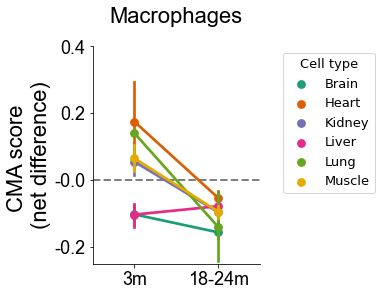

In [7]:
# CMA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='net_score', data=barcode[barcode.new_cell.isin(['macrophage', 'lung macrophage',
                                                                             'Kupffer cell'])], hue='tissue', 
              order=["3m", "18-24m"], hue_order=['brain', 'heart', 'kidney', 'liver', 'lung', 'limb muscle'], 
              palette='Dark2', ci=68)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(-0.25, 0.40) 
ax.set_yticks([-0.20, -0.0, 0.20, 0.40])
ax.set_yticklabels([-0.20, -0.0, 0.20, 0.40], fontdict={'family':'Arial', 'size': 18})
plt.title(label='Macrophages', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Legend
tissues = ['Brain', 'Heart', 'Kidney', 'Liver', 'Lung', 'Muscle', 'Pancreas']
h, l = ax.get_legend_handles_labels()
ax.legend(h, tissues, bbox_to_anchor=(1.1, 1), title="Cell type", title_fontsize = "13", fontsize=13) 

plt.savefig('../Khwaja_et_al_outputs/AllTissues/Mphg_alltis_ns.png',bbox_inches='tight', dpi=300)

plt.show()

In [63]:
cell_list = ['neuron', 'interneuron', 'astrocyte', 'oligodendrocyte', 'microglial cell', 'myocyte', 'smooth muscle cell', 
             'heart fibroblast', 'heart endothelial cell', 'mesangial cell', 'fenestrated cell', 'proximal tubule epithelial cell',
             'collecting duct epithelial cell', 'hepatocyte', 'Kupffer cell', 'pneumocyte', 'lung fibroblast', 
             'lung endothelial cell', 'skeletal muscle satellite cell', 'pancreatic acinar cell', 'pancreatic A cell', 
             'type B pancreatic cell']

In [65]:
pal = {'neuron':'#009933', 'interneuron':'#26b359', 'astrocyte':'#43c676', 'oligodendrocyte':'#60d993', 
       'microglial cell':'#86f2b9', 'myocyte':'#0000ff', 'smooth muscle cell':'#2633ff', 'heart fibroblast':'#4359ff', 
       'heart endothelial cell':'#6080ff', 'mesangial cell':'#800000', 'fenestrated cell':'#933340', 
       'proximal tubule epithelial cell':'#a15970', 'collecting duct epithelial cell':'#b0809f', 
       'hepatocyte':'#cc9900', 'Kupffer cell':'#dcb950', 'pneumocyte':'#660066', 'lung fibroblast':'#8c408c',
       'lung endothelial cell':'#b380b3', 'skeletal muscle satellite cell':'#d95900', 'pancreatic acinar cell':'#794d20', 
       'pancreatic A cell':'#967350', 'type B pancreatic cell':'#b39980'}

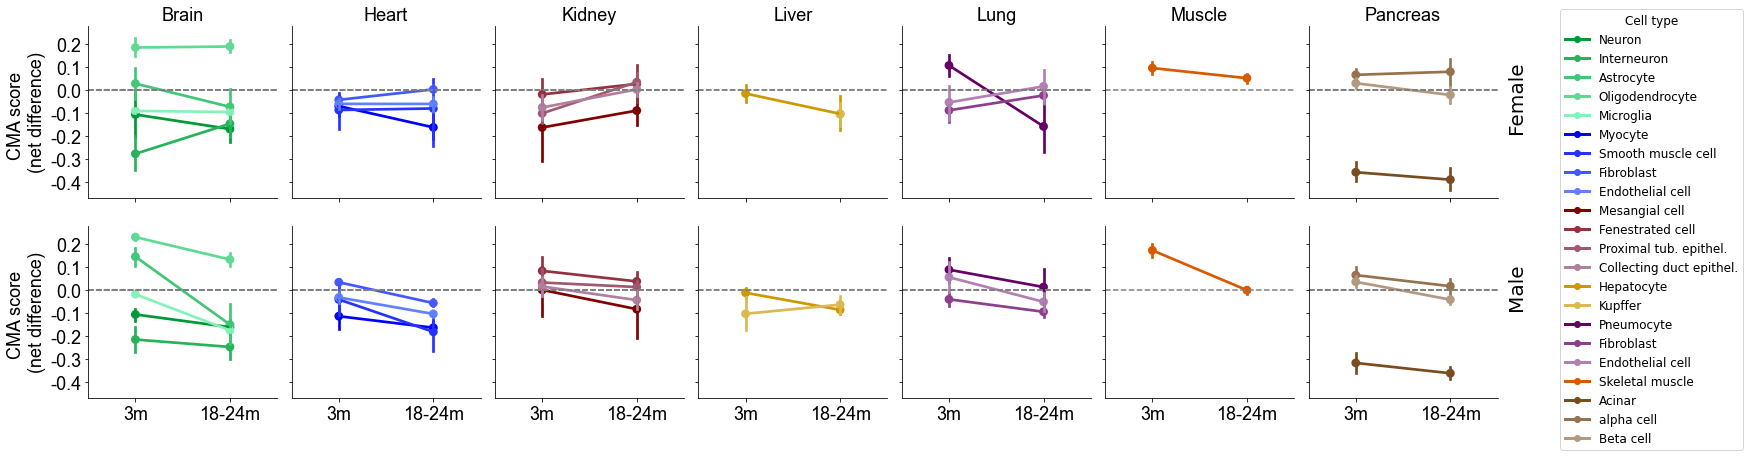

In [77]:
g = sns.FacetGrid(barcode, col="tissue", row='sex', hue='new_cell2', hue_order=cell_list, palette=pal)
g.map_dataframe(sns.pointplot, x="new_age", y="net_score")
g.set_ylabels("CMA score \n(net difference)", fontdict={'family':'Arial', 'size': 18})
g.set_xlabels("")
g.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
g.set(yticks=[-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2])
g.set_yticklabels([-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2], fontdict={'family':'Arial', 'size': 18})
g.map(plt.axhline, y=0, ls="--", c="gray")
#g.set_titles("{row_names}")
axes = g.axes.flatten()
axes[0].set_title("Brain", fontdict={'family':'Arial', 'size': 18})
axes[1].set_title("Heart", fontdict={'family':'Arial', 'size': 18})
axes[2].set_title("Kidney", fontdict={'family':'Arial', 'size': 18})
axes[3].set_title("Liver", fontdict={'family':'Arial', 'size': 18})
axes[4].set_title("Lung", fontdict={'family':'Arial', 'size': 18})
axes[5].set_title("Muscle", fontdict={'family':'Arial', 'size': 18})
axes[6].set_title("Pancreas", fontdict={'family':'Arial', 'size': 18})
axes[7].set_title("")
axes[8].set_title("")
axes[9].set_title("")
axes[10].set_title("")
axes[11].set_title("")
axes[12].set_title("")
axes[13].set_title("")
plt.text(1.6, 0.7, "Female", fontsize=20, rotation=90)
plt.text(1.6, -0.07, "Male", fontsize=20, rotation=90)
#g.add_legend()

legend_elements = [Line2D([0], [0], color='#009933',marker='o', lw=3, label='Neuron'),
                   Line2D([0], [0], color='#26b359', marker='o', lw=3, label='Interneuron'),
                   Line2D([0], [0], color='#43c676', marker='o', lw=3, label='Astrocyte'),
                   Line2D([0], [0], color='#60d993', marker='o', lw=3, label='Oligodendrocyte'),
                   Line2D([0], [0], color='#86f2b9', marker='o', lw=3, label='Microglia'),
                  Line2D([0], [0], color='#0000ff',marker='o', lw=3, label='Myocyte'),
                  Line2D([0], [0], color='#2633ff',marker='o', lw=3, label='Smooth muscle cell'),
                  Line2D([0], [0], color='#4359ff',marker='o', lw=3, label='Fibroblast'),
                  Line2D([0], [0], color='#6080ff',marker='o', lw=3, label='Endothelial cell'),
                  Line2D([0], [0], color='#800000',marker='o', lw=3, label='Mesangial cell'),
                  Line2D([0], [0], color='#933340',marker='o', lw=3, label='Fenestrated cell'),
                  Line2D([0], [0], color='#a15970',marker='o', lw=3, label='Proximal tub. epithel.'),
                  Line2D([0], [0], color='#b0809f',marker='o', lw=3, label='Collecting duct epithel.'),
                  Line2D([0], [0], color='#cc9900',marker='o', lw=3, label='Hepatocyte'),
                  Line2D([0], [0], color='#dcb950',marker='o', lw=3, label='Kupffer'),
                  Line2D([0], [0], color='#660066',marker='o', lw=3, label='Pneumocyte'),
                  Line2D([0], [0], color='#8c408c',marker='o', lw=3, label='Fibroblast'),
                  Line2D([0], [0], color='#b380b3',marker='o', lw=3, label='Endothelial cell'),
                  Line2D([0], [0], color='#d95900',marker='o', lw=3, label='Skeletal muscle'),
                  Line2D([0], [0], color='#794d20',marker='o', lw=3, label='Acinar'),
                  Line2D([0], [0], color='#967350',marker='o', lw=3, label='alpha cell'),
                  Line2D([0], [0], color='#b39980',marker='o', lw=3, label='Beta cell')]

plt.legend(handles = legend_elements, bbox_to_anchor = (1.3, 2.3), title="Cell type", title_fontsize = 12, fontsize=12)

plt.savefig('../Khwaja_et_al_outputs/AllTissues/All_ns_bysex.png',bbox_inches='tight', dpi=300)

plt.show()

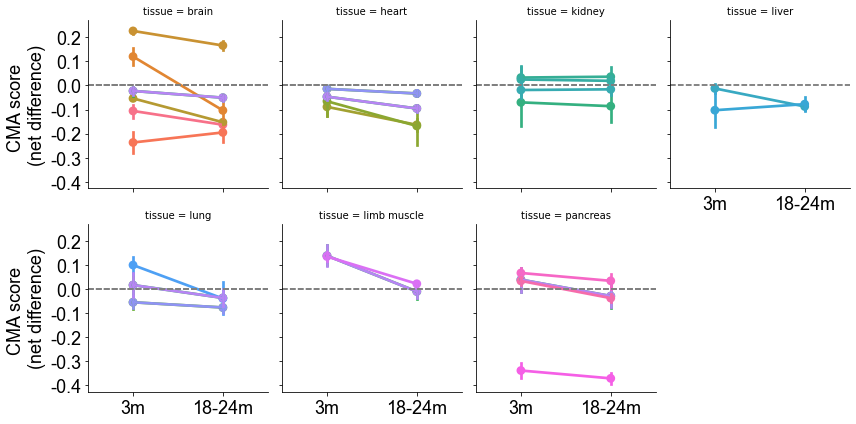

In [225]:
# Not used for now
g = sns.FacetGrid(barcode, col="tissue", hue='new_cell', hue_order=cell_list, col_wrap=4)
g.map_dataframe(sns.pointplot, x="new_age", y="net_score")
g.set_ylabels("CMA score \n(net difference)", fontdict={'family':'Arial', 'size': 18})
g.set_xlabels("")
g.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
g.set(yticks=[-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2])
g.set_yticklabels([-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2], fontdict={'family':'Arial', 'size': 18})
g.map(plt.axhline, y=0, ls="--", c="gray")

plt.show()

## DEGs comparisons

Interesting to compare:
    - 2 populations which cma score goes down differently, differences by sex and with age
    - Same population , differences with age in gene expression depending on cma score

In [3]:
adata.obs.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,tissue,self_reported_ethnicity,development_stage,score,umap_density_tissue,_tmp_embedding_density_column_7382_,new_age,net_score,new_cell,tissue_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6891.192383,31,...,pancreas,na,18 month-old stage,-0.145108,0.599144,0.599144,18-24m,-0.200220,type B pancreatic cell,-0.211025
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B000927,nan,facs,18_46_F,Muscle Diaphragm,2789,2543.752930,12,...,limb muscle,na,18 month-old stage,-0.104981,0.939589,-1.000000,18-24m,-0.160093,skeletal muscle satellite cell,-0.286631
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3588.732910,1,...,heart,na,18 month-old stage,0.063537,0.017321,-1.000000,18-24m,0.008425,B cell,0.031444
A10_B003294_B007450_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B003294,nan,facs,18_47_F,Muscle forelimb and hindlimb,1838,3994.461182,12,...,limb muscle,na,18 month-old stage,0.184838,0.768057,-1.000000,18-24m,0.129726,skeletal muscle satellite cell,0.003188
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,6017.255371,31,...,pancreas,na,18 month-old stage,0.009996,0.838215,0.838215,18-24m,-0.045116,type B pancreatic cell,-0.055921


In [15]:
# Subsetting only for tissues of interest
adata = adata[(adata.obs['cell_type']=='skeletal muscle satellite cell') & (adata.obs['sex']=='female')]
print(adata.shape)

(1020, 21069)


In [17]:
adata.X

<1020x21069 sparse matrix of type '<class 'numpy.float32'>'
	with 1954908 stored elements in Compressed Sparse Row format>

In [14]:
adata_m = adata[(adata.obs['new_cell']=='skeletal muscle satellite cell') & (adata.obs['sex']=='male')]
print(adata_m.shape)

(1026, 21069)


In [19]:
# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)


In [20]:
sc.tl.rank_genes_groups(adata, 'age', method='t-test_overestim_var', key_added = "t-test_ov")

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\scanpy\tools\_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\scanpy\tools\_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\scanpy\tools\_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\scanpy\tools\_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
C:\Users\Adrian\an

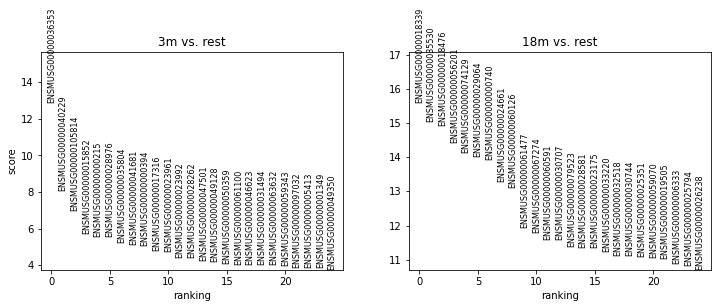

In [21]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test_ov")

In [34]:
var = var.set_index('feature_name')
var

,feature_id,n_cells,means,dispersions,dispersions_norm,highly_variable,feature_is_filtered,feature_reference,feature_biotype
feature_name,,,,,,,,,
Rsrc2,ENSMUSG00000029422,65053,0.661381,1.699014,-0.777653,False,False,NCBITaxon:10090,gene
Mir669b,ENSMUSG00000076126,20,0.000020,0.132460,-1.863719,False,False,NCBITaxon:10090,gene
Tmem121,ENSMUSG00000049036,3000,0.035558,1.571166,-0.467672,False,False,NCBITaxon:10090,gene
Ube3b,ENSMUSG00000029577,22639,0.192207,2.119273,0.064183,False,False,NCBITaxon:10090,gene
Rnf167,ENSMUSG00000040746,52908,0.951327,2.185473,-0.478167,False,False,NCBITaxon:10090,gene
...,...,...,...,...,...,...,...,...,...
4930590L20Rik,ENSMUSG00000102368,121,0.000335,0.563086,-1.445862,False,False,NCBITaxon:10090,gene
Gstz1,ENSMUSG00000021033,21213,0.303598,2.144145,0.088317,False,False,NCBITaxon:10090,gene
Hbb-bt,ENSMUSG00000073940,6988,0.763634,6.496391,3.915612,True,False,NCBITaxon:10090,gene


In [33]:
var = var.reset_index()
var

,feature_id,n_cells,means,dispersions,dispersions_norm,highly_variable,feature_is_filtered,feature_name,feature_reference,feature_biotype
0,ENSMUSG00000029422,65053,0.661381,1.699014,-0.777653,False,False,Rsrc2,NCBITaxon:10090,gene
1,ENSMUSG00000076126,20,0.000020,0.132460,-1.863719,False,False,Mir669b,NCBITaxon:10090,gene
2,ENSMUSG00000049036,3000,0.035558,1.571166,-0.467672,False,False,Tmem121,NCBITaxon:10090,gene
3,ENSMUSG00000029577,22639,0.192207,2.119273,0.064183,False,False,Ube3b,NCBITaxon:10090,gene
4,ENSMUSG00000040746,52908,0.951327,2.185473,-0.478167,False,False,Rnf167,NCBITaxon:10090,gene
...,...,...,...,...,...,...,...,...,...,...
21064,ENSMUSG00000102368,121,0.000335,0.563086,-1.445862,False,False,4930590L20Rik,NCBITaxon:10090,gene
21065,ENSMUSG00000021033,21213,0.303598,2.144145,0.088317,False,False,Gstz1,NCBITaxon:10090,gene
21066,ENSMUSG00000073940,6988,0.763634,6.496391,3.915612,True,False,Hbb-bt,NCBITaxon:10090,gene
21067,ENSMUSG00000037924,68,0.002103,4.602207,2.473495,False,False,Olfr16,NCBITaxon:10090,gene


In [31]:
var = adata.var.copy()

In [27]:
adata.var

,n_cells,means,dispersions,dispersions_norm,highly_variable,feature_is_filtered,feature_name,feature_reference,feature_biotype
feature_id,,,,,,,,,
ENSMUSG00000029422,65053,0.661381,1.699014,-0.777653,False,False,Rsrc2,NCBITaxon:10090,gene
ENSMUSG00000076126,20,0.000020,0.132460,-1.863719,False,False,Mir669b,NCBITaxon:10090,gene
ENSMUSG00000049036,3000,0.035558,1.571166,-0.467672,False,False,Tmem121,NCBITaxon:10090,gene
ENSMUSG00000029577,22639,0.192207,2.119273,0.064183,False,False,Ube3b,NCBITaxon:10090,gene
ENSMUSG00000040746,52908,0.951327,2.185473,-0.478167,False,False,Rnf167,NCBITaxon:10090,gene
...,...,...,...,...,...,...,...,...,...
ENSMUSG00000102368,121,0.000335,0.563086,-1.445862,False,False,4930590L20Rik,NCBITaxon:10090,gene
ENSMUSG00000021033,21213,0.303598,2.144145,0.088317,False,False,Gstz1,NCBITaxon:10090,gene
ENSMUSG00000073940,6988,0.763634,6.496391,3.915612,True,False,Hbb-bt,NCBITaxon:10090,gene


In [23]:
adata.uns

OverloadedDict, wrapping:
	{'leiden': {'params': {'n_iterations': array([-1], dtype=int64), 'random_state': array([0], dtype=int64), 'resolution': array([1], dtype=int64)}}, 'louvain': {'params': {'random_state': array([0], dtype=int64)}}, 'louvain_colors': array(['#FF4A46', '#A30059', '#7A4900', '#B79762', '#004D43'],
      dtype=object), 'neighbors': {'params': {'method': array(['umap'], dtype=object), 'metric': array(['euclidean'], dtype=object), 'n_neighbors': array([15], dtype=int64)}}, 'pca': {'variance': array([68.67417865, 64.40481218, 54.5024679 , 48.73195997, 45.53409491,
       33.64244787, 32.56955686, 28.12147524, 26.80380652, 20.98551294,
       18.98206374, 18.58138654, 17.63605705, 17.26227746, 15.90086895,
       15.46866851, 14.8120697 , 13.51183306, 12.43220157, 11.63213864,
       11.39020443, 10.39998804,  9.48617615,  9.04700344,  8.62089097,
        8.52585316,  7.95842582,  7.57111058,  7.30663536,  6.80935478,
        6.33471617,  5.95010794,  5.79513504,  5.53

In [25]:
tt = adata.uns['t-test_ov']['names']

In [26]:
tt

rec.array([('ENSMUSG00000036353', 'ENSMUSG00000018339'),
           ('ENSMUSG00000040229', 'ENSMUSG00000035530'),
           ('ENSMUSG00000105814', 'ENSMUSG00000018476'), ...,
           ('ENSMUSG00000018476', 'ENSMUSG00000105814'),
           ('ENSMUSG00000035530', 'ENSMUSG00000040229'),
           ('ENSMUSG00000018339', 'ENSMUSG00000036353')],
          dtype=[('3m', 'O'), ('18m', 'O')])

## Macro score

### Preprocessing

In [2]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad('../Exp. 2_Tabula muris/Files/TM_all_smartseq.h5ad')

# Subsetting only for tissues of interest
adata = adata[adata.obs['tissue'].isin(['pancreas', 'heart', 'brain', 'lung', 'liver', 'kidney', 'limb muscle'])]

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\scanpy\preprocessing\_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


### MA score calculation

In [9]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/MA_model.xlsx')

# Removing ATG9B, HTT, PRKAA1, PRKAA2 and VPS11 genes because they don't appear in the adata
model_matrix = model_matrix.drop([8, 37, 43, 44, 58], axis=0).reset_index(drop=True)

# Finding MA network genes in the dataset
ma_network = adata[:, model_matrix["Ms_ENSM"]]

In [12]:
# Calculating the Zs scores
ma_data_zs = ma_network.copy().X.todense().T

for i in tqdm(np.arange(ma_data_zs.shape[0])):
    
    µ = np.mean(ma_data_zs[i, :])
    sd = np.std(ma_data_zs[i, :])
    
    ma_data_zs[i, :] = (ma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = ma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'ma_score'] = score   
    

100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 201.63it/s]
47484it [07:39, 103.43it/s]


In [14]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-24m'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = '18-24m'

In [16]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['ma_score'])

for i in tqdm(barcode.index):
    barcode.loc[i, 'ma_nscore'] = barcode.loc[i, 'ma_score'] - µ 

100%|██████████████████████████████████████████████████████████████████████████| 47484/47484 [00:05<00:00, 7918.38it/s]


In [18]:
tissues = ['pancreas', 'limb muscle', 'heart', 'brain', 'lung', 'liver', 'kidney']

In [20]:
# Function for testing normality using D'Agostino-Pearson of different cell types and ages
def normalidad (df, tipo, años):
    long = []
    cell = []
    age = []
    estadistica=[]
    pval=[]
    result=[]   
    
    for x in tipo:
        for y in años:
            mydata = df[(df['tissue']== x) & (df['new_age']== y)]
            n = len(mydata.index)
            data = list(mydata.ma_nscore)            
            stat, p = normaltest(data)
            long.append(n)
            cell.append(x)
            age.append(y)
            estadistica.append(stat)
            pval.append(p)
            if p > 0.05:
                result.append("Normal")
            else:
                result.append("Not normal")    
    df_norm = pd.DataFrame({"Cell": cell, "Age": age, "n": long, "Stat":estadistica, "p value": pval, "Result":result})
    return(df_norm)

In [21]:
normalidad(barcode, tipo=tissues, años=['3m', '18-24m'])

,Cell,Age,n,Stat,p value,Result
0,pancreas,3m,1588,41.335779,1.056938e-09,Not normal
1,pancreas,18-24m,1796,134.177604,7.306401e-30,Not normal
2,limb muscle,3m,1102,5.387983,6.761054e-02,Normal
3,limb muscle,18-24m,2753,50.703745,9.768360e-12,Not normal
4,heart,3m,4433,58.531362,1.950187e-13,Not normal
5,heart,18-24m,5236,474.111890,1.116635e-103,Not normal
6,brain,3m,7974,316.244468,2.130033e-69,Not normal
7,brain,18-24m,12692,623.786169,3.520096e-136,Not normal
8,lung,3m,1381,17.010490,2.024040e-04,Not normal
9,lung,18-24m,3837,87.116955,1.210023e-19,Not normal


In [22]:
# Calculating MWU test for not normally distributed cell types
for i in tissues:
    group3 = list(barcode[barcode.tissue==i][barcode.new_age=='3m']['ma_nscore'])
    group18_24 = list(barcode[barcode.tissue==i][barcode.new_age=='18-24m']['ma_nscore'])
    print('{} statistics'.format(i.title()))
    stat, p = stats.mannwhitneyu(group3, group18_24)
    print("MWU test pval = " + str(p))
    print('\n')

C:\Users\Adrian\AppData\Local\Temp\ipykernel_11432\1205056814.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.tissue==i][barcode.new_age=='3m']['ma_nscore'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_11432\1205056814.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.tissue==i][barcode.new_age=='18-24m']['ma_nscore'])


Pancreas statistics
MWU test pval = 2.5053794142313308e-46


Limb Muscle statistics
MWU test pval = 1.7674078866966088e-91


Heart statistics
MWU test pval = 6.989932208093333e-56


Brain statistics
MWU test pval = 5.194249340316938e-263


Lung statistics
MWU test pval = 9.401214310698347e-06


Liver statistics
MWU test pval = 1.1964316158172764e-32


Kidney statistics
MWU test pval = 0.9837754736868676




### MA net score for tissues

C:\Users\Adrian\AppData\Local\Temp\ipykernel_11432\4279680787.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y1= np.mean(barcode[barcode.tissue =='brain'][barcode.new_age=='18-24m']['ma_nscore']) - (0.019)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_11432\4279680787.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y2= np.mean(barcode[barcode.tissue =='heart'][barcode.new_age=='18-24m']['ma_nscore']) - (0.019)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_11432\4279680787.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y4= np.mean(barcode[barcode.tissue =='liver'][barcode.new_age=='18-24m']['ma_nscore']) - (0.019)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_11432\4279680787.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y5= np.mean(barcode[barcode.tissue =='lung'][barcode.new_age=='18-24m']['ma_nscore']) - (0.019)
C:\Users\Adrian\AppData\L

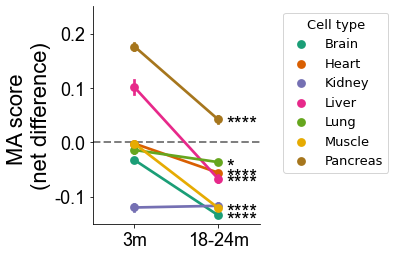

In [32]:
# MA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='ma_nscore', data=barcode, hue='tissue', order=["3m", "18-24m"], 
              hue_order=['brain', 'heart', 'kidney', 'liver', 'lung', 'limb muscle', 'pancreas'], palette="Dark2", ci=68)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('MA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(-0.15, 0.25) 
ax.set_yticks([-0.10, 0.00, 0.10, 0.20])
ax.set_yticklabels([-0.10, 0.00, 0.10, 0.20], fontdict={'family':'Arial', 'size': 18})

# Legend
tissues = ['Brain', 'Heart', 'Kidney', 'Liver', 'Lung', 'Muscle', 'Pancreas']
h, l = ax.get_legend_handles_labels()
ax.legend(h, tissues, bbox_to_anchor=(1.1, 1), title="Cell type", title_fontsize = "13", fontsize=13) 

# Stats
x1= 1.1   
y1= np.mean(barcode[barcode.tissue =='brain'][barcode.new_age=='18-24m']['ma_nscore']) - (0.019)
y2= np.mean(barcode[barcode.tissue =='heart'][barcode.new_age=='18-24m']['ma_nscore']) - (0.019)
y4= np.mean(barcode[barcode.tissue =='liver'][barcode.new_age=='18-24m']['ma_nscore']) - (0.019)
y5= np.mean(barcode[barcode.tissue =='lung'][barcode.new_age=='18-24m']['ma_nscore']) - (0.019)
y6= np.mean(barcode[barcode.tissue =='limb muscle'][barcode.new_age=='18-24m']['ma_nscore']) - (0.019)
y7= np.mean(barcode[barcode.tissue =='pancreas'][barcode.new_age=='18-24m']['ma_nscore']) - (0.019)

plt.text(x1, y1, "****", fontsize=20, **hfont)
plt.text(x1, y2, "****", fontsize=20, **hfont)
plt.text(x1, y4, "****", fontsize=20, **hfont)
plt.text(x1, y5, "*", fontsize=20, **hfont)
plt.text(x1, y6, "****", fontsize=20, **hfont)
plt.text(x1, y7, "****", fontsize=20, **hfont)

plt.savefig('../Khwaja_et_al_outputs/AllTissues/Tissues_MAns.png',bbox_inches='tight', dpi=300)

plt.show()

### MA net score Liver

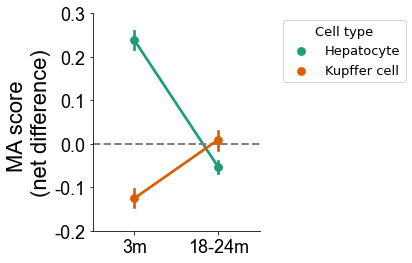

In [35]:
# MA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='ma_nscore', data=barcode, hue='cell_type', order=["3m", "18-24m"], 
              hue_order=['hepatocyte', 'Kupffer cell'], palette="Dark2", ci=68)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('MA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(-0.20, 0.30) 
ax.set_yticks([-0.20, -0.10, 0.00, 0.10, 0.20, 0.30])
ax.set_yticklabels([-0.20, -0.10, 0.00, 0.10, 0.20, 0.30], fontdict={'family':'Arial', 'size': 18})

# Legend
tissues = ['Hepatocyte', 'Kupffer cell']
h, l = ax.get_legend_handles_labels()
ax.legend(h, tissues, bbox_to_anchor=(1.1, 1), title="Cell type", title_fontsize = "13", fontsize=13) 

'''# Stats
x1= 1.1   
y6= np.mean(barcode[barcode.tissue =='limb muscle'][barcode.new_age=='18-24m']['ma_nscore']) - (0.019)
y7= np.mean(barcode[barcode.tissue =='pancreas'][barcode.new_age=='18-24m']['ma_nscore']) - (0.019)

plt.text(x1, y6, "****", fontsize=20, **hfont)
plt.text(x1, y7, "****", fontsize=20, **hfont)'''

plt.savefig('../Khwaja_et_al_outputs/AllTissues/Liver_MAns.png',bbox_inches='tight', dpi=300)

plt.show()

### MA heatmap

In [91]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((74, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(ma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(ma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(ma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(ma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd         
         
    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(12,20))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, cmap='viridis', vmax=1.5, vmin=-1.5)
    plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=14, **hfont)

    plt.yticks(np.arange(74), model_matrix['Gene name'], fontsize=14, **hfont)

    plt.ylim(73.5, -0.5)

    plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=14, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.01)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans = ax.get_yaxis_transform()
    trans2 = ax.get_xaxis_transform()
    ax.annotate('Effectors', xy=(-2.15, 10.5), xycoords=trans, ha='left', rotation=90, va="center", 
                color='k', size=16, **hfont)
    ax.plot([-1.75,-1.75],[-0.25, 19.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Pos. regulators', xy=(-2.15, 38.75), xycoords=trans, ha='left', rotation=90, va="center", 
                color='green', size=16, **hfont)
    ax.plot([-1.75,-1.75],[19.75, 58.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Neg. regulators', xy=(-2.15, 66.25), xycoords=trans, ha='left', rotation=90, va="center", 
                color='red', size=16, **hfont)
    ax.plot([-1.75,-1.75],[58.75, 73.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Fem.', xy=(0.1, -0.065), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.055,-.055], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('Male', xy=(2.8, -.065), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.055,-.055], color="k", transform=trans2, clip_on=False)
    
    plt.savefig('../Khwaja_et_al_outputs/AllTissues/{}_heat.png'.format(cellpop),bbox_inches='tight', dpi=300)
    plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_11432\3272957158.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_11432\3272957158.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_11432\3272957158.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_11432\3272957158.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] 

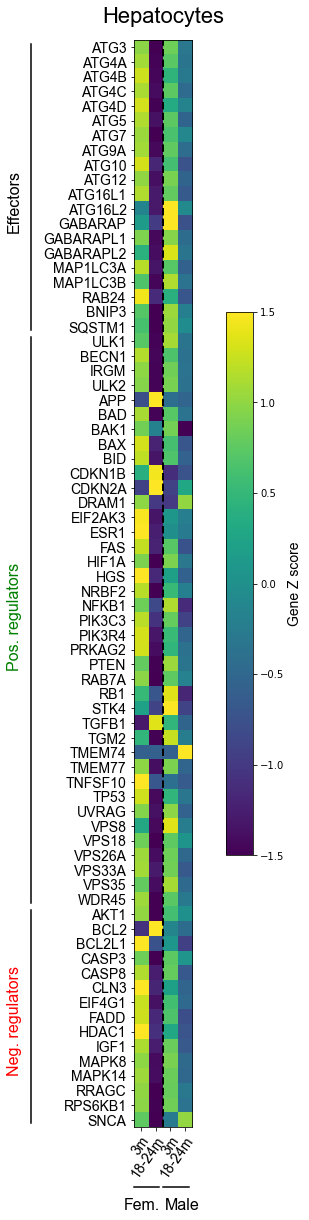

In [94]:
sex_heatmaps(cellpop='hepatocyte')

In [127]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((74, 3))
    
    #Find cell indices for each condition
    female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(ma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(ma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(ma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd         
         
    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(12,16))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, cmap='viridis', vmax=1.5, vmin=-1.5)
    plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=14, **hfont)

    plt.yticks(np.arange(74), model_matrix['Gene name'], fontsize=14, **hfont)

    plt.ylim(73.5, -0.5)

    plt.xticks(np.arange(3), ['18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=14, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.01)
    
    plt.axvline(x=0.6, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans = ax.get_yaxis_transform()
    trans2 = ax.get_xaxis_transform()
    ax.annotate('Effectors', xy=(-3.15, 10.5), xycoords=trans, ha='left', rotation=90, va="center", 
                color='k', size=16, **hfont)
    ax.plot([-2.6,-2.6],[-0.25, 19.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Pos. regulators', xy=(-3.15, 38.75), xycoords=trans, ha='left', rotation=90, va="center", 
                color='green', size=16, **hfont)
    ax.plot([-2.6,-2.6],[19.75, 58.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Neg. regulators', xy=(-3.15, 66.25), xycoords=trans, ha='left', rotation=90, va="center", 
                color='red', size=16, **hfont)
    ax.plot([-2.6,-2.6],[58.75, 73.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Fem.', xy=(-0.15, -0.073), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,0.25],[-.065,-.065], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('Male', xy=(2.5, -.073), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1., 2.5],[-.065,-.065], color="k", transform=trans2, clip_on=False)
    
    plt.savefig('../Khwaja_et_al_outputs/AllTissues/{}_heat.png'.format(cellpop),bbox_inches='tight', dpi=300)
    plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_11432\2249862688.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_11432\2249862688.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_11432\2249862688.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:03<00:00, 18.56it/s]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_11432\2249862688.py:25: Ru

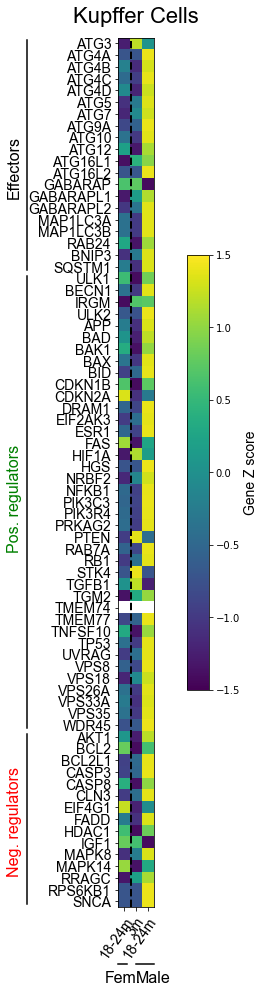

In [128]:
sex_heatmaps(cellpop='Kupffer cell')